In [39]:
import uuid

import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from scripts.general import preprocess
from scripts.general.attribution import load_patterns, load_patterns_and_meta, load_profiles


def left_align(df: pd.DataFrame):
    """https://stackoverflow.com/a/63869860"""
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df


## Load sequence and domain data

In [2]:
# ATTENTION_DIR = '../results/20211223_182228/'
ATTENTION_DIR = '.'

In [3]:
sequences = preprocess.fasta_to_seq_df(
    '../../data/seq/scerevisiae_aminoacid_uniprot_20200120_seqlen_100_to_1000.fasta'
)   
yeast_ids = sequences['swissprot_ac'].values

domains = pd.read_csv('../../data/interpro/yeast_protein2ipr.csv.gz')
domains = domains.query('uniprot_ac in @yeast_ids').rename(columns={'uniprot_ac': 'swissprot_ac'})
db_names = {
    'PS': 'PROSITE',
    'cd': 'CDD',
    'PR': 'PRINTS',
    'SS': 'SUPERFAMILY',
    'PF': 'Pfam',
    'SM': 'SMART',
    'G3': 'CATH-Gene3D',
    'TI': 'TIGRFAMs',
    'PT': 'PANTHER',
    'SF': 'SFLD',
    'PI': 'PIRSF',
    'MF': 'HAMAP'
}
domains = domains.assign(
    db = domains['db_id'].map(lambda db_id: db_names[db_id[0:2]])
)

ip_entries = pd.read_csv('../../data/interpro/entry.list', sep='\t')
ip_entries.columns = ip_entries.columns.str.lower()
domains = pd.merge(
    domains,
    ip_entries[['entry_ac', 'entry_type']],
    on = 'entry_ac'
)

domains = pd.merge(
    domains,
    sequences.assign(seq_len = sequences['seq'].str.len()).drop(columns = 'seq'),
    on = 'swissprot_ac'
)

# Assign unique ID to each domain entry 
domains = domains.assign(
    dom_id = [uuid.uuid4().hex for _ in range(domains.shape[0])]
)

domains = domains.assign(
    dom_len = domains['end'] + 1 - domains['start']
)

print('N. domains: ', domains.shape[0])
print('N. proteins:', domains['swissprot_ac'].unique().shape[0])
domains.head()

N. domains:  27902
N. proteins: 4577


,swissprot_ac,entry_ac,entry_name,db_id,start,end,db,entry_type,seq_len,dom_id,dom_len
0,Q05015,IPR005645,Serine hydrolase FSH,PF03959,2,214,Pfam,Domain,223,40d77b2157174e088b4e3d1794dbf492,213
1,Q05015,IPR029058,Alpha/Beta hydrolase fold,G3DSA:3.40.50.1820,2,223,CATH-Gene3D,Homologous_superfamily,223,51e2f1192cca40de9531e91533a9cb16,222
2,Q05015,IPR029058,Alpha/Beta hydrolase fold,SSF53474,5,220,SUPERFAMILY,Homologous_superfamily,223,7e749647390a4ece9c47d38b9b364315,216
3,P38777,IPR005645,Serine hydrolase FSH,PF03959,2,229,Pfam,Domain,243,783dcab610fc44278969141f0bccbea0,228
4,P38777,IPR029058,Alpha/Beta hydrolase fold,G3DSA:3.40.50.1820,1,243,CATH-Gene3D,Homologous_superfamily,243,93a39405cfd84e15be76c94eb88acfaf,243


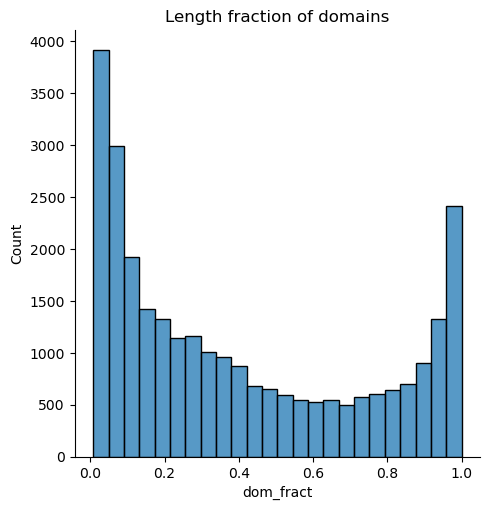

In [4]:
plt.rcParams['figure.dpi'] = 100

sns.displot(
    domains
        .assign(dom_fract = domains['dom_len'] / domains['seq_len']),
    x = 'dom_fract',
)
_ = plt.title('Length fraction of domains')

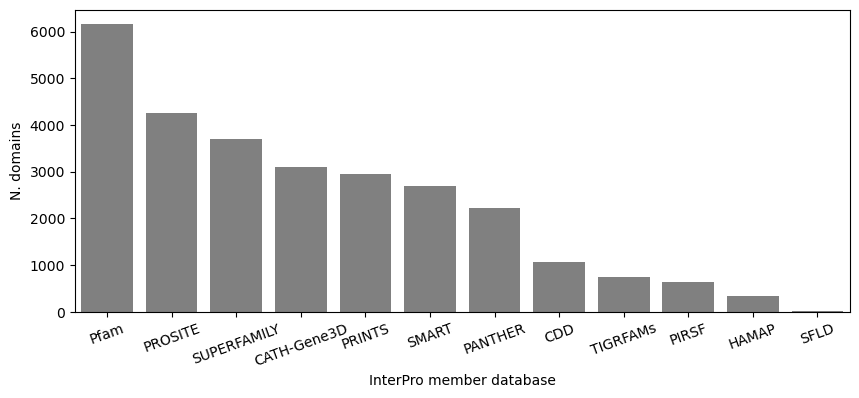

In [5]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 4)

p_db_counts = sns.countplot(
    data = domains,
    x = 'db',
    color = 'gray',
    order = domains['db'].value_counts().index
)

p_db_counts.set_xticklabels(labels=p_db_counts.get_xticklabels(), rotation=20)
plt.ylabel('N. domains')
_ = plt.xlabel('InterPro member database')

## Qualitative: Attention pattern coverage of each domain

In [6]:
short_domains = domains[
    domains['dom_len'] / domains['seq_len'] <= 0.5
]

short_domains.shape[0]

18000

In [7]:
short_domains['attention_pattern'] = short_domains['swissprot_ac'].map(
    lambda prot_id: load_patterns(prot_id, attention_dir = ATTENTION_DIR, grouping='lists')[0]
)
short_domains = short_domains[~short_domains['attention_pattern'].isna()]
short_domains = short_domains.explode('attention_pattern')

WARN: Could not load pattern for P0CX09 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P0CX09.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P0CX09 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P0CX09.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P0CX09 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P0CX09.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P0CX09 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P0CX09.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P0CX09 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for P53117 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P53117.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q05473 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q05473.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q12175 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q12175.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q12175 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q12175.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q12175 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for Q08347 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q08347.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08347 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q08347.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08347 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q08347.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08347 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q08347.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08347 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for Q04364 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q04364.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q04364 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q04364.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q04364 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q04364.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q04364 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q04364.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q04364 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for P24719 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P24719.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P24719 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P24719.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P24719 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P24719.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P24719 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P24719.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P24719 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for P17261 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P17261.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P17261 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P17261.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P17261 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P17261.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P17261 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P17261.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P53147 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for Q07798 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q07798.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q07798 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q07798.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q06551 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q06551.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q03289 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q03289.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08743 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for Q08844 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q08844.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08844 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q08844.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08905 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q08905.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08905 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_Q08905.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for Q08905 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for P0CX59 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P0CX59.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P0CX60 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P0CX60.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P0CX61 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P0CX61.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P0CX62 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P0CX62.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P0CX65 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for P25380 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P25380.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P25380 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P25380.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P32907 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P32907.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P53916 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P53916.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P53916 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for P03870 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P03870.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P03881 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P03881.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P03881 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P03881.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P03881 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P03881.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P03881 : [Errno 2] Unable to open file (unable to open file: name = 'attent

WARN: Could not load pattern for P21592 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P21592.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P21592 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P21592.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P32572 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P32572.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P32572 : [Errno 2] Unable to open file (unable to open file: name = 'attention_patterns/attention_P32572.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
WARN: Could not load pattern for P32572 : [Errno 2] Unable to open file (unable to open file: name = 'attent

<ipython-input-7-9ddc2a931804>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_domains['attention_pattern'] = short_domains['swissprot_ac'].map(


In [8]:
short_domains.shape[0]

63895

In [9]:
from scripts.general.attribution import coverage_fract_in_window, mean_coverage_outside_window

short_domains = short_domains.assign(
    fract_coverage = short_domains.apply(
        lambda row: coverage_fract_in_window(row['attention_pattern'], row['start'] - 1, row['end']), 
        axis='columns'
    ),
    
    control_coverage = short_domains.apply(
        lambda row: mean_coverage_outside_window(row['attention_pattern'], row['start'] - 1, row['end']), 
        axis='columns'
    ),
).reset_index(drop=True)

short_domains = short_domains.loc[short_domains.groupby('dom_id')['fract_coverage'].idxmax()]

### Significance test

In [10]:
dom_coverage = (
    short_domains
    .rename(columns={'fract_coverage': 'Domain', 'control_coverage': 'Control'})
    .melt(
        id_vars = ['swissprot_ac', 'db'],
        value_vars = ['Domain', 'Control'],
        var_name = 'partition',
        value_name = 'coverage_fract'
    )
)

In [11]:
def signif_test(grp_df):
    coverage = grp_df.pivot_table(
        index = 'swissprot_ac',
        columns = 'partition',
        values = 'coverage_fract'
    )
    res = stats.wilcoxon(
        x = coverage['Control'].values.ravel(), 
        y = coverage['Domain'].values.ravel()
    )
    return {'db': grp_df['db'].values[0], 'wilcoxon_stat': res[0], 'p-value': res[1]}


signif_coverage = pd.DataFrame.from_records(
    dom_coverage.groupby('db').apply(signif_test)
)

signif_coverage.query('`p-value` < 0.05')

,db,wilcoxon_stat,p-value
0,CATH-Gene3D,102913.0,2.628080e-121
1,CDD,20278.0,3.513764e-29
3,PANTHER,122.0,2.647258e-15
4,PIRSF,24.0,7.366570e-05
5,PRINTS,2047.0,5.363761e-87
6,PROSITE,233302.0,1.031458e-184
7,Pfam,304049.0,1.992423e-225
9,SMART,74466.0,4.534368e-104
10,SUPERFAMILY,127359.0,3.016269e-122
11,TIGRFAMs,1129.0,3.518823e-04


In [12]:
print(signif_coverage.query('`p-value` < 0.05').shape[0], 'out of', signif_coverage.shape[0], 'DBs')

10 out of 12 DBs


In [13]:
signif_diff_dbs = signif_coverage.query('`p-value` < 0.05')['db'].values

dom_coverage_for_plot = dom_coverage.query('db in @signif_diff_dbs')

dom_coverage_for_plot.to_csv('yeast_interpr_attention_domains_overlap.csv.gz', index=False, compression='gzip')

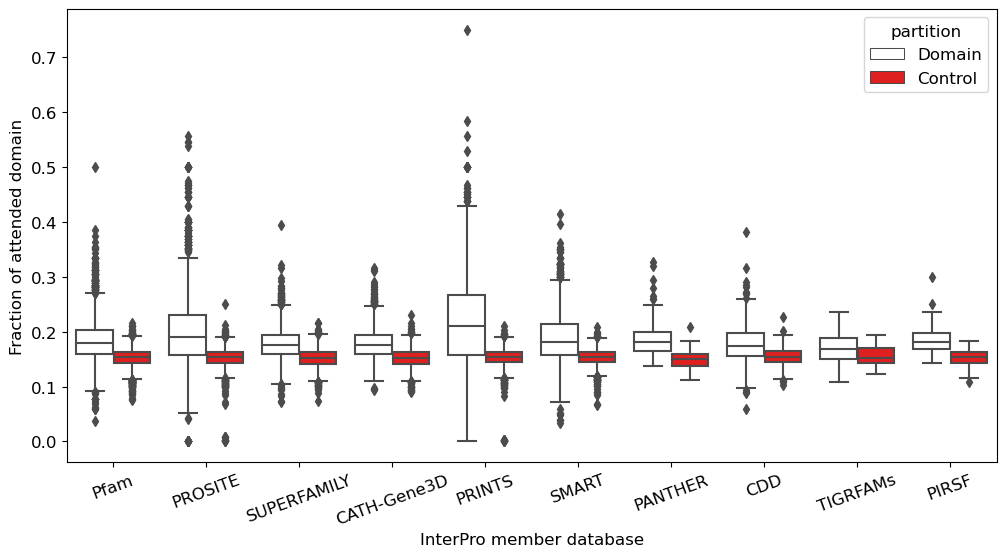

In [14]:
plt.figure(dpi=100, figsize=(12, 6))
plt.rcParams['font.size'] = 12

p_coverage = sns.boxplot(
    data = dom_coverage_for_plot, 
    x = 'db',
    hue = 'partition',
    y = 'coverage_fract',
    order = domains.query('db in @signif_diff_dbs')['db'].value_counts().index,
    palette={'Domain': 'white', 'Control': 'red'}
)

p_coverage.set_xticklabels(labels=p_coverage.get_xticklabels(), rotation=20)
plt.ylabel('Fraction of attended domain')
_ = plt.xlabel('InterPro member database')


p_coverage.figure.savefig('domain_coverage.pdf', dpi=100)

In [15]:
cutoff_coverage_fract = 0.3

In [16]:
well_covered_domains = (
    short_domains
    .query('db in @signif_diff_dbs')
    .query('fract_coverage >= @cutoff_coverage_fract')
)

print('N. domains:  ', well_covered_domains.shape[0])
print('N. proteins: ', well_covered_domains['swissprot_ac'].unique().shape[0])

N. domains:   832
N. proteins:  517


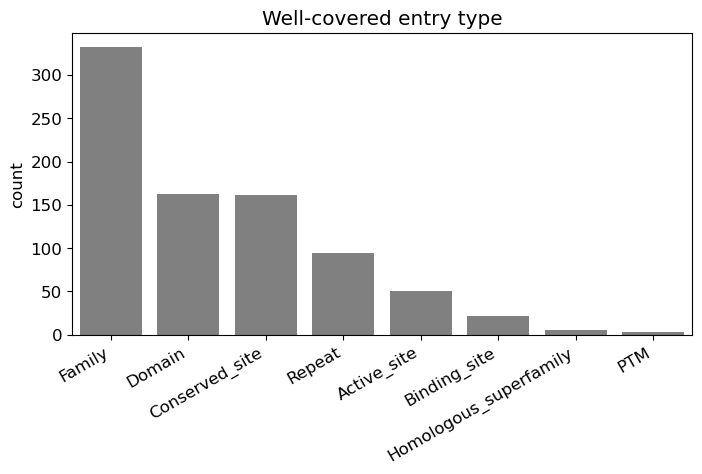

In [17]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8, 4)

covered_domains = short_domains.query('fract_coverage >= @cutoff_coverage_fract')

p_type_counts = sns.countplot(
    data = covered_domains,
    x = 'entry_type',
    color = 'gray',
    order = covered_domains['entry_type'].value_counts().index
)

_ = p_type_counts.set_xticklabels(labels=p_type_counts.get_xticklabels(), rotation=30, horizontalalignment='right')
_ = p_type_counts.set_title('Well-covered entry type')
_ = p_type_counts.set_xlabel('')

p_type_counts.figure.savefig('wellcovered_entry_types.pdf', dpi=100)

In [18]:
well_covered_domains.to_csv('well_covered_domains.csv.gz', index=False, compression='gzip')

In [19]:
covered_domains.head()

,swissprot_ac,entry_ac,entry_name,db_id,start,end,db,entry_type,seq_len,dom_id,dom_len,attention_pattern,fract_coverage,control_coverage
19109,P50102,IPR018200,"Ubiquitin specific protease, conserved site",PS00973,411,428,PROSITE,Conserved_site,471,000622047820482ca11dad718adfcbea,18,--------Q--------D-------------N-----------MK-...,0.333333,0.165563
46639,Q12525,IPR017226,"Betaine-homocysteine S-methyltransferase, BHMT",PIRSF037505,273,322,PIRSF,Family,324,00420521118e4453857c490eaa9d09cf,50,----------V----K----D--Q---------N-----W------...,0.300000,0.156934
7204,P39743,IPR001452,SH3 domain,PR00452,468,480,PRINTS,Domain,482,0042fda56c494b0595aa7527192e68cb,13,---K---K-----------K--------D-VY-D---------Q--...,0.307692,0.166311
59110,P28789,IPR000860,Porphobilinogen deaminase,PR00151,80,99,PRINTS,Family,327,00bd360795e349d5aff4abe215d1e519,20,---E-L------S---------V--L----Y------V-----L--...,0.350000,0.143322
45902,P38626,IPR001834,NADH:cytochrome b5 reductase-like,PR00406,246,254,PRINTS,Family,284,013e1daefc7a43ae9eddde26457a9867,9,---D----V-V----V---------------V-----N--------...,0.333333,0.156364


Text(0, 0.5, 'Well-covered domain count')

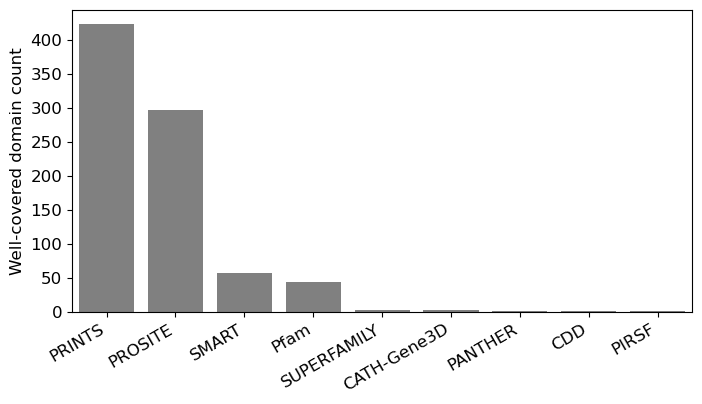

In [20]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8, 4)

p_type_counts = sns.countplot(
    data = covered_domains,
    x = 'db',
    color = 'gray',
    order = covered_domains['db'].value_counts().index
)

_ = p_type_counts.set_xticklabels(labels=p_type_counts.get_xticklabels(), rotation=30, horizontalalignment='right')
_ = p_type_counts.set_xlabel('')
plt.ylabel('Well-covered domain count')

### Attention head domain specialization

In [21]:
attention_meta = []

for prot_id in well_covered_domains['swissprot_ac'].unique():
    att_pattern, meta = load_patterns_and_meta(prot_id, attention_dir = ATTENTION_DIR)
    meta = meta.assign(swissprot_ac = prot_id)
    meta['attention_pattern'] = att_pattern
    attention_meta.append(meta)

attention_meta = pd.concat(attention_meta, ignore_index=False)

well_covered_domains_and_meta = pd.merge(
    attention_meta,
    well_covered_domains,
    on = ['swissprot_ac', 'attention_pattern']
)

well_covered_domains_and_meta['layer'] = well_covered_domains_and_meta['layer'].astype(np.uint8)
well_covered_domains_and_meta['head'] = well_covered_domains_and_meta['head'].astype(np.uint8)

In [22]:
well_covered_domains_and_meta.groupby('layer')['attention_pattern'].count()

layer
4      1
5     87
6    744
Name: attention_pattern, dtype: int64

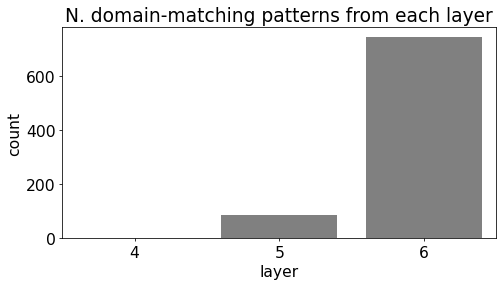

<Figure size 560x280 with 0 Axes>

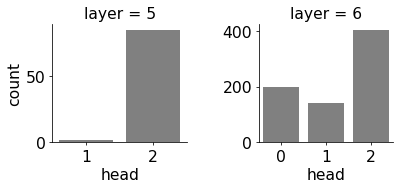

In [23]:
plt.rcParams['figure.dpi'] = 70
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = 16

plt.figure(1)
sns.countplot(x=well_covered_domains_and_meta['layer'], color='gray')
_ = plt.title('N. domain-matching patterns from each layer')

_ = plt.figure(2)
g = sns.FacetGrid(well_covered_domains_and_meta.query('layer>=5'), col="layer", sharex=False, sharey=False)
g.map_dataframe(sns.countplot, x='head', color='gray')
_ = g.set_axis_labels('head', 'count')

## Abundances of proteins with well-covered domains

In [24]:
abundances = pd.read_csv('../../data/ho2018/prot_abundance_molecules_per_cell_no_gfp.csv')[
    ['swissprot_ac', 'Median_molecules_per_cell']
]
abundances = abundances.assign(
    abundance_bin = pd.qcut(abundances['Median_molecules_per_cell'], q = 10, labels=range(1, 11))
)

top_domains_and_abundance = pd.merge(
    well_covered_domains[['swissprot_ac', 'dom_id', 'db']],
    abundances,
    on='swissprot_ac'
)

domains_and_abundance = pd.merge(   
    short_domains[['swissprot_ac', 'dom_id', 'db']],
    abundances,
    on='swissprot_ac'
)

Text(0, 0.5, 'Well-covered domain count')

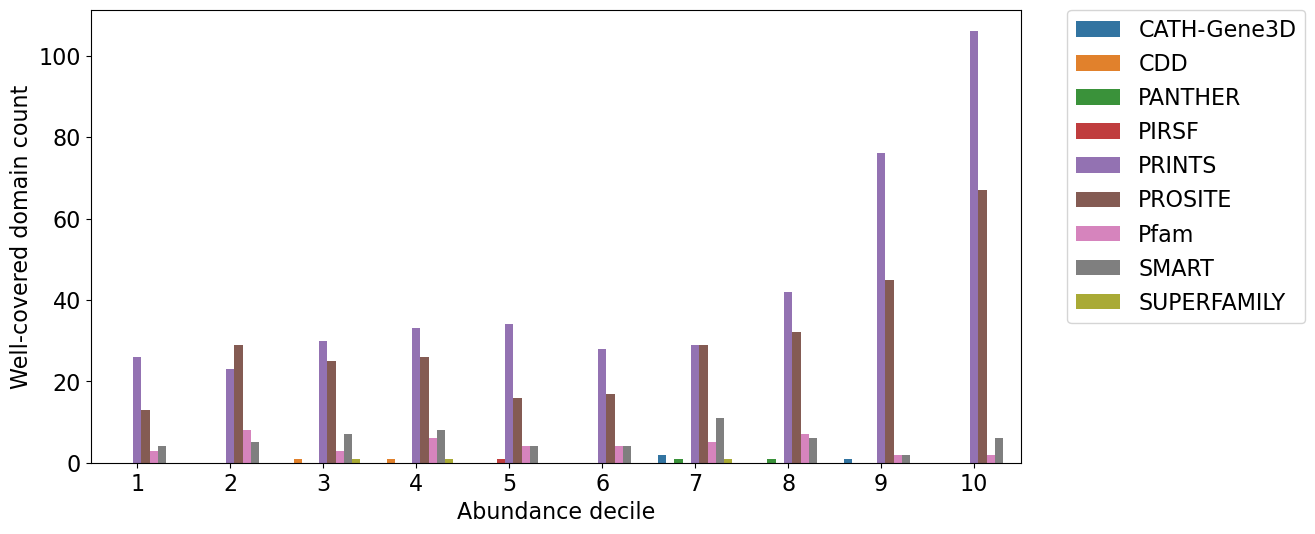

In [25]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 16

sns.countplot(
    data = top_domains_and_abundance.sort_values('db'),
    x = 'abundance_bin',
    hue = 'db'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Abundance decile')
plt.ylabel('Well-covered domain count')

Text(0, 0.5, 'Domain count')

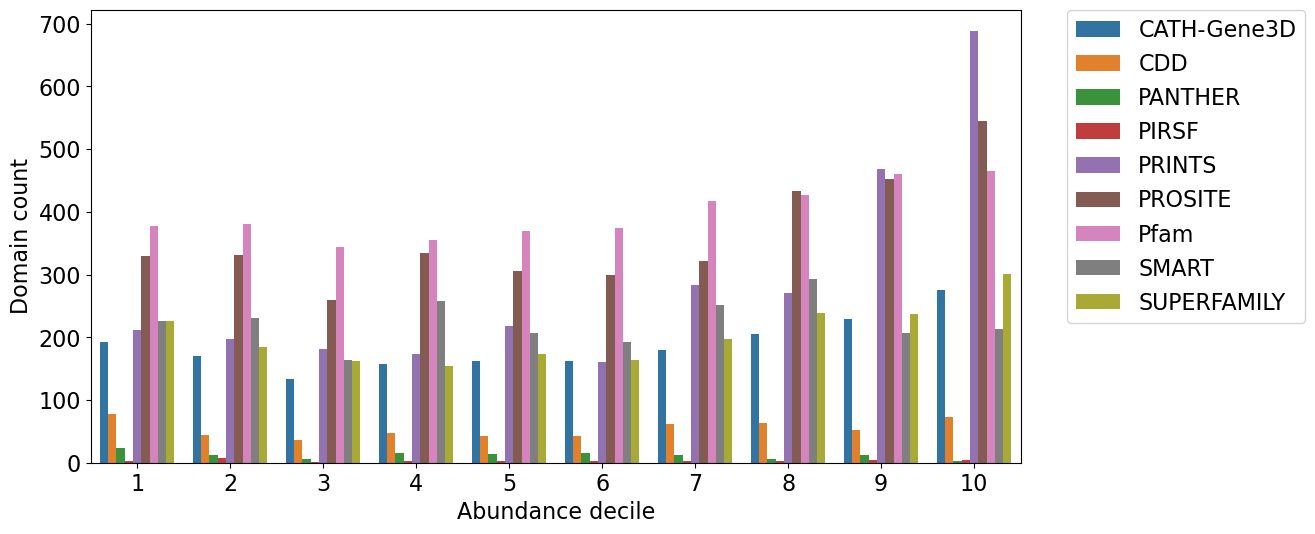

In [26]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 16

matched_db_names = top_domains_and_abundance['db'].unique()

sns.countplot(
    data = domains_and_abundance.query('db in @matched_db_names').sort_values('db'),
    x = 'abundance_bin',
    hue = 'db'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Abundance decile')
plt.ylabel('Domain count')

### Conclusion

The amount of well-covered domains pretty much follows the overall DB domain counts across abundance deciles, with some deviations:

- abundance decile 4 has relatively more well-covered PROSITE domains than PRINTS, compared to the domain count
- Pfma has relatively few well-cvoered domains generally

## GO terms for well-covered domains

In [27]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()

obodag = GODag(obo_fname)

objanno = Gene2GoReader(fin_gene2go, taxids=[559292])
ns2assoc = objanno.get_ns2assc()

yeast_gene_prot_ids = pd.read_csv('../../data/seq/yeast_gene_entries_2020_02_26.csv')
yeast_gene_list = pd.read_csv('../../data/s288c_genes_ncbi_20210305.tsv', sep='\t')
yeast_gene_list['Aliases'] = yeast_gene_list['Aliases'].str.split(',')
yeast_gene_list = yeast_gene_list.explode('Aliases')

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2021-12-15) 47,157 GO Terms
HMS:0:00:01.947479  94,342 annotations,  6,413 genes,  6,081 GOs, 1 taxids READ: gene2go 


## GO-term analysis of proteins with (any) well-covered domains

In [28]:
goeaobj = GOEnrichmentStudyNS(
    yeast_gene_list['GeneID'].unique().tolist(),
    ns2assoc, # geneid/GO associations
    obodag,   # Ontologies
    propagate_counts = False,
    alpha = 0.05,
    methods = ['fdr_bh']
)


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 87%  5,249 of  6,003 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 93%  5,564 of  6,003 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 76%  4,590 of  6,003 population items found in association


In [29]:
well_covered_domains_oln = pd.merge(
    short_domains.query('fract_coverage >= @cutoff_coverage_fract'),
    yeast_gene_prot_ids,
    on = 'swissprot_ac'
)['OLN'].unique()

well_covered_domains_prot_ids = yeast_gene_list.query('Aliases in @well_covered_domains_oln')['GeneID'].unique().tolist()

In [30]:
fname = 'dominss_go_enrichments_tmp.tsv'

FDR_CUTOFF = 0.05

goea_results = goeaobj.run_study(well_covered_domains_prot_ids)
goea_results_significant = [r for r in goea_results if r.p_fdr_bh < FDR_CUTOFF]
goeaobj.wr_tsv(fname, goea_results_significant)

domains_goea_results = pd.read_csv(fname, sep='\t').sort_values('p_fdr_bh').rename(columns={'# GO': 'go_term'})

! rm {fname}

domains_goea_results.to_csv('domains_go_enrichments.csv', index=False)


Run BP Gene Ontology Analysis: current study set of 522 IDs ... 98%    513 of    522 study items found in association
100%    522 of    522 study items found in population(6003)
Calculating 3,163 uncorrected p-values using fisher_scipy_stats
   3,163 GO terms are associated with  5,249 of  6,003 population items
   1,087 GO terms are associated with    513 of    522 study items
  METHOD fdr_bh:
      19 GO terms found significant (< 0.05=alpha) ( 19 enriched +   0 purified): statsmodels fdr_bh
     177 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 522 IDs ... 97%    508 of    522 study items found in association
100%    522 of    522 study items found in population(6003)
Calculating 826 uncorrected p-values using fisher_scipy_stats
     826 GO terms are associated with  5,564 of  6,003 population items
     304 GO terms are associated with    508 of    52

In [31]:
domains_goea_results.query('NS == "BP"')

,go_term,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0016310,BP,e,phosphorylation,46/522,211/6003,2.376855e-09,5,46,0.000004,"850366, 850402, 850453, 850803, 850941, 850950..."
1,GO:0006457,BP,e,protein folding,27/522,88/6003,2.556256e-09,2,27,0.000004,"850314, 850433, 850636, 850914, 850963, 851259..."
2,GO:0042026,BP,e,protein refolding,14/522,27/6003,8.275568e-09,3,14,0.000009,"850636, 850914, 850963, 851259, 851369, 853418..."
3,GO:0051085,BP,e,chaperone cofactor-dependent protein refolding,11/522,18/6003,3.514667e-08,5,11,0.000023,"850636, 851259, 851369, 853418, 853503, 854185..."
4,GO:0006412,BP,e,translation,52/522,274/6003,3.621215e-08,7,52,0.000023,"850643, 850737, 850996, 851169, 851260, 851369..."
5,GO:0006096,BP,e,glycolytic process,13/522,26/6003,5.070455e-08,12,13,0.000027,"851193, 851541, 852495, 853106, 853155, 853169..."
6,GO:0034620,BP,e,cellular response to unfolded protein,8/522,11/6003,4.048859e-07,6,8,0.000166,"850636, 851259, 851369, 853418, 853503, 855512..."
7,GO:0006418,BP,e,tRNA aminoacylation for protein translation,13/522,30/6003,4.209233e-07,10,13,0.000166,"850643, 851607, 851861, 853081, 853640, 854056..."
8,GO:0006468,BP,e,protein phosphorylation,30/522,141/6003,2.719049e-06,7,30,0.000956,"850366, 850453, 850803, 850941, 850950, 851274..."
9,GO:0006333,BP,e,chromatin assembly or disassembly,9/522,18/6003,6.319222e-06,5,9,0.001999,"851810, 851811, 852283, 852284, 852294, 852295..."


In [32]:
domains_goea_results.query('NS == "MF"')

,go_term,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
42,GO:0000166,MF,e,nucleotide binding,137/522,775/6003,7.097494e-18,4,137,1.473440e-14,"850327, 850366, 850402, 850453, 850504, 850506..."
43,GO:0005524,MF,e,ATP binding,118/522,669/6003,2.935001e-15,8,118,3.046531e-12,"850327, 850366, 850402, 850453, 850504, 850625..."
44,GO:0016301,MF,e,kinase activity,46/522,206/6003,1.038303e-09,4,46,7.185056e-07,"850366, 850402, 850453, 850803, 850941, 850950..."
45,GO:0046872,MF,e,metal ion binding,116/522,785/6003,1.495461e-09,4,116,7.337026e-07,"850327, 850372, 850402, 850584, 850664, 850733..."
46,GO:0016491,MF,e,oxidoreductase activity,55/522,274/6003,1.767106e-09,2,55,7.337026e-07,"850327, 850759, 851146, 851237, 851238, 851351..."
47,GO:0031072,MF,e,heat shock protein binding,10/522,19/6003,1.020758e-06,3,10,2.267384e-04,"850636, 851259, 851369, 853418, 853503, 855512..."
48,GO:0004672,MF,e,protein kinase activity,29/522,128/6003,1.029024e-06,5,29,2.267384e-04,"850366, 850453, 850803, 850941, 850950, 851274..."
49,GO:0051082,MF,e,unfolded protein binding,22/522,82/6003,1.054439e-06,3,22,2.267384e-04,"850314, 850636, 850914, 850963, 851259, 851369..."
51,GO:0008186,MF,e,"ATP-dependent activity, acting on RNA",8/522,12/6003,1.122336e-06,2,8,2.267384e-04,"852539, 852704, 853303, 853419, 853933, 854211..."
52,GO:0004674,MF,e,protein serine/threonine kinase activity,28/522,122/6003,1.201408e-06,6,28,2.267384e-04,"850366, 850453, 850803, 850950, 851274, 851396..."


In [33]:
domains_goea_results.query('NS == "CC"')

,go_term,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
19,GO:0000786,CC,e,nucleosome,11/522,11/6003,1.950905e-12,3,11,1.611448e-09,"851810, 851811, 852283, 852284, 852294, 852295..."
20,GO:0005737,CC,e,cytoplasm,288/522,2477/6003,2.254541e-11,2,288,9.311254e-09,"850318, 850327, 850346, 850361, 850366, 850402..."
22,GO:0005829,CC,e,cytosol,107/522,791/6003,9.416579e-07,2,107,1.944524e-04,"850327, 850346, 850636, 850643, 850733, 850807..."
21,GO:0031298,CC,e,replication fork protection complex,12/522,27/6003,8.503054e-07,3,12,1.944524e-04,"850980, 851810, 851811, 852258, 852283, 852284..."
23,GO:0000015,CC,e,phosphopyruvate hydratase complex,5/522,5/6003,4.885293e-06,3,5,8.070504e-04,"853169, 854575, 855373, 855848, 856579"
38,GO:0016021,CC,p,integral component of membrane,68/522,1223/6003,6.474086e-06,3,68,8.912659e-04,"850368, 850433, 850490, 850713, 850770, 850888..."
24,GO:0005856,CC,e,cytoskeleton,29/522,155/6003,6.301532e-05,5,29,6.510605e-03,"850450, 850504, 850506, 850909, 851274, 851532..."
25,GO:0005739,CC,e,mitochondrion,138/522,1172/6003,6.305671e-05,5,138,6.510605e-03,"850361, 850366, 850368, 850538, 850580, 850636..."
39,GO:0016020,CC,p,membrane,119/522,1788/6003,2.066581e-04,2,119,1.896662e-02,"850368, 850433, 850490, 850647, 850713, 850770..."
26,GO:0030479,CC,e,actin cortical patch,14/522,58/6003,3.317577e-04,3,14,2.740318e-02,"850450, 850504, 850580, 851532, 851996, 853037..."


In [34]:
from goatools.obo_parser import GODag
from goatools.mapslim import mapslim


from scripts.general.analysis import get_goslims_for_ids
    
    
goea_slim_terms = get_goslims_for_ids(domains_goea_results['go_term'].unique().tolist(),
                                      GODag('../../data/go/goslim_yeast.obo'),
                                      obodag)
    
display(goea_slim_terms.query('aspect == "BP"'))
display(goea_slim_terms.query('aspect == "MF"'))
display(goea_slim_terms.query('aspect == "CC"'))

goea_slim_terms.to_csv('domains_go_enrichments_slims.csv', index=False)

../../data/go/goslim_yeast.obo: fmt(1.2) rel(None) 287 GO Terms


,go_id,aspect,go_term
1,GO:0006091,BP,generation of precursor metabolites and energy
3,GO:0055086,BP,nucleobase-containing small molecule metabolic...
4,GO:0006418,BP,tRNA aminoacylation for protein translation
6,GO:0006457,BP,protein folding
7,GO:0042221,BP,response to chemical
8,GO:0006414,BP,translational elongation
12,GO:0008150,BP,biological_process
25,GO:0006325,BP,chromatin organization
26,GO:0006605,BP,protein targeting
27,GO:0006417,BP,regulation of translation


,go_id,aspect,go_term
0,GO:0051082,MF,unfolded protein binding
2,GO:0016740,MF,transferase activity
5,GO:0016829,MF,lyase activity
9,GO:0016887,MF,ATP hydrolysis activity
10,GO:0016301,MF,kinase activity
11,GO:0140657,MF,ATPase-dependent activity
13,GO:0008135,MF,"translation factor activity, RNA binding"
15,GO:0008092,MF,cytoskeletal protein binding
16,GO:0003924,MF,GTPase activity
17,GO:0008233,MF,peptidase activity


,go_id,aspect,go_term
14,GO:0005737,CC,cytoplasm
20,GO:0005856,CC,cytoskeleton
21,GO:0005739,CC,mitochondrion
32,GO:0005783,CC,endoplasmic reticulum
38,GO:0016020,CC,membrane
40,GO:0005575,CC,cellular_component


In [40]:
goea_slim_terms.groupby('aspect').apply(lambda gdf: display(gdf['aspect'].values[0], 
                                                            left_align(gdf[['go_term']])))

'BP'

,go_term
1,generation of precursor metabolites and energy
3,nucleobase-containing small molecule metabolic process
4,tRNA aminoacylation for protein translation
6,protein folding
7,response to chemical
8,translational elongation
12,biological_process
25,chromatin organization
26,protein targeting
27,regulation of translation


'CC'

,go_term
14,cytoplasm
20,cytoskeleton
21,mitochondrion
32,endoplasmic reticulum
38,membrane
40,cellular_component


'MF'

,go_term
0,unfolded protein binding
2,transferase activity
5,lyase activity
9,ATP hydrolysis activity
10,kinase activity
11,ATPase-dependent activity
13,"translation factor activity, RNA binding"
15,cytoskeletal protein binding
16,GTPase activity
17,peptidase activity


""
